In [1]:
# Libraries
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
import seaborn as sns
import gc


sns.set()

In [2]:
# Train data
train = pd.read_csv("data_files/train.csv", header = 0)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int64
meter            int64
timestamp        object
meter_reading    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB


In [3]:
# Building meta data
building = pd.read_csv("data_files/building_metadata.csv")
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [4]:
# Weather train data
weather_train = pd.read_csv("data_files/weather_train.csv")
weather_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int64
timestamp             139773 non-null object
air_temperature       139718 non-null float64
cloud_coverage        70600 non-null float64
dew_temperature       139660 non-null float64
precip_depth_1_hr     89484 non-null float64
sea_level_pressure    129155 non-null float64
wind_direction        133505 non-null float64
wind_speed            139469 non-null float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB


In [5]:
del train, building, weather_train
_ = gc.collect()

In [6]:
def memory_reduction(df):
    itypes = [np.int8, np. int16, np.int32, np.int64] 
    ftypes = [np.float16, np.float32, np.float64]
    iinfo = [np.iinfo(t) for t in itypes]
    finfo = [np.finfo(t) for t in ftypes]
    for col in df:
        if is_numeric_dtype(df[col]):
            col_max = df[col].max()
            col_min = df[col].min()
            if np.issubdtype(df[col].dtype, np.integer):
                for ii in iinfo:
                    if col_min >= ii.min and col_max <= ii.max:
                        df[col] = df[col].astype(ii.dtype)
                        break
            else:
                for fi in finfo:
                    if col_min >= fi.min and col_max <= fi.max:
                        df[col] = df[col].astype(fi.dtype)
                        break
    return df

In [7]:
def load_data(base, task):
    train = memory_reduction(pd.read_csv(f"{base}/{task}.csv", parse_dates = ['timestamp']))
    building = memory_reduction(pd.read_csv(f"{base}/building_metadata.csv"))
    weather = memory_reduction(pd.read_csv(f"{base}/weather_{task}.csv", parse_dates = ['timestamp']))
    return train.merge(building.merge(weather, on = "site_id", how = "left"), how = "left", on = ["building_id", "timestamp"])

In [8]:
train = load_data("data_files", "train")
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
building_id           int16
meter                 int8
timestamp             datetime64[ns]
meter_reading         float32
site_id               float64
primary_use           object
square_feet           float64
year_built            float16
floor_count           float16
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
dtypes: datetime64[ns](1), float16(9), float32(1), float64(2), int16(1), int8(1), object(1)
memory usage: 1.2+ GB


In [9]:
test = load_data("data_files", "test")
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 16 columns):
row_id                int32
building_id           int16
meter                 int8
timestamp             datetime64[ns]
site_id               float64
primary_use           object
square_feet           float64
year_built            float16
floor_count           float16
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
dtypes: datetime64[ns](1), float16(9), float64(2), int16(1), int32(1), int8(1), object(1)
memory usage: 2.5+ GB


## EDA

### Null Values

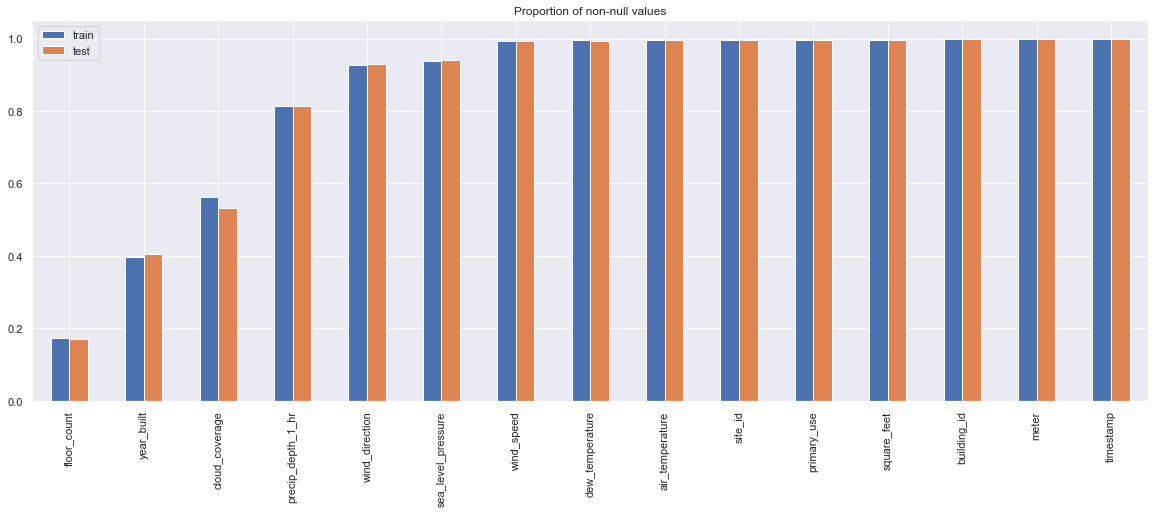

In [10]:
plt.clf()
(train.count()/len(train)).sort_values().to_frame("train").merge((test.count()/len(test)).to_frame("test"), left_index = True, right_index = True).plot.bar(title = "Proportion of non-null values", figsize = (20, 7))

### Target Variable - Meter Reading

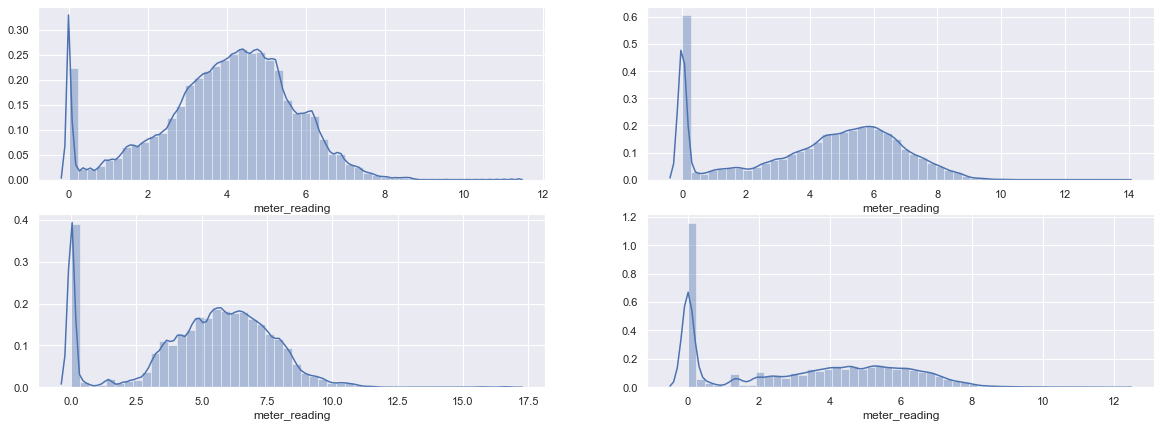

In [11]:
plt.clf()
grouped = train[["meter", "meter_reading"]].groupby("meter")
fig, ax = plt.subplots(2, 2, figsize = (20, 7))
i = j = 0
for name, group in grouped:
    _ = sns.distplot(np.log1p(group['meter_reading']), ax = ax[i, j], label = name)
    if j == 0:
        j+=1
    else:
        i += 1
        j = 0

There seeems to a lot of rows with 0 meter reading.

In [12]:
# Summary of meter readings
train['meter_reading'].describe()

count    2.021610e+07
mean     1.988706e+03
std      1.532159e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

There seems to be a lot of rows with 0 meter readings. Let's see the proportion of data with 0 meter reading..

In [13]:
# Percentage of traininig data with 0 meter_reading
round(train.loc[train.meter_reading == 0, 'meter_reading'].count()*100/len(train), 2)

9.27

Checking the distribution of mean meter reading over time..
Inspired By [EDA for ASHRAE](https://www.kaggle.com/nroman/eda-for-ashrae)

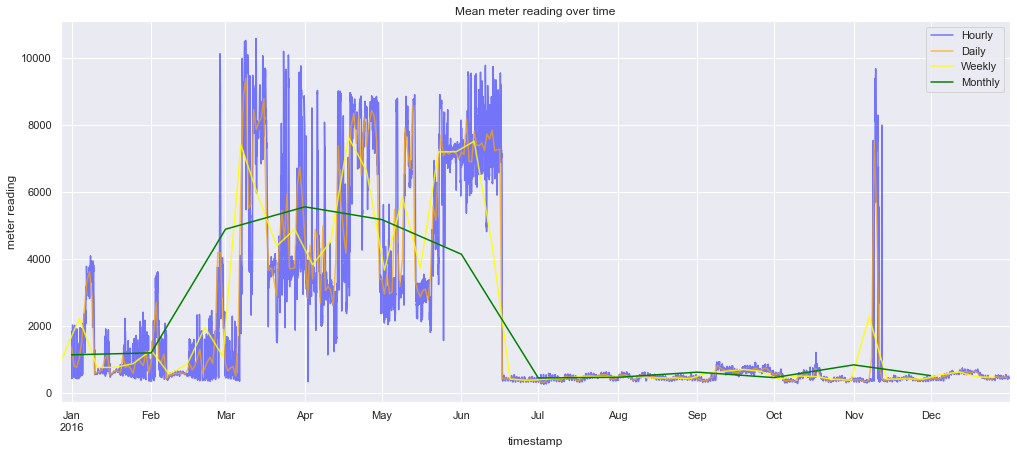

In [14]:
# Mean meter reading over time
plt.clf()
fig, ax = plt.subplots(figsize = (17, 7))
train[["timestamp", "meter_reading"]].set_index("timestamp").resample("H").mean()["meter_reading"].plot(ax = ax, label = "Hourly", color = "blue", alpha = 0.5)
train[["timestamp", "meter_reading"]].set_index("timestamp").resample("D").mean()["meter_reading"].plot(ax = ax, label = "Daily", color = "orange", alpha = 0.7)
train[["timestamp", "meter_reading"]].set_index("timestamp").resample("W").mean()["meter_reading"].plot(ax = ax, label = "Weekly", color = "yellow", alpha = 0.85)
train[["timestamp", "meter_reading"]].set_index("timestamp").resample("M").mean()["meter_reading"].plot(ax = ax, label = "Monthly", color = "green", alpha = 1)
ax.set_title("Mean meter reading over time")
ax.set_ylabel("meter reading")
ax.legend(loc = "best")

The graph has weird surges from the months of May to June and then again around Novemeber. Let's facet the graph using site_id to see if a particular region is responsible for this anomaly.

<Figure size 432x288 with 0 Axes>

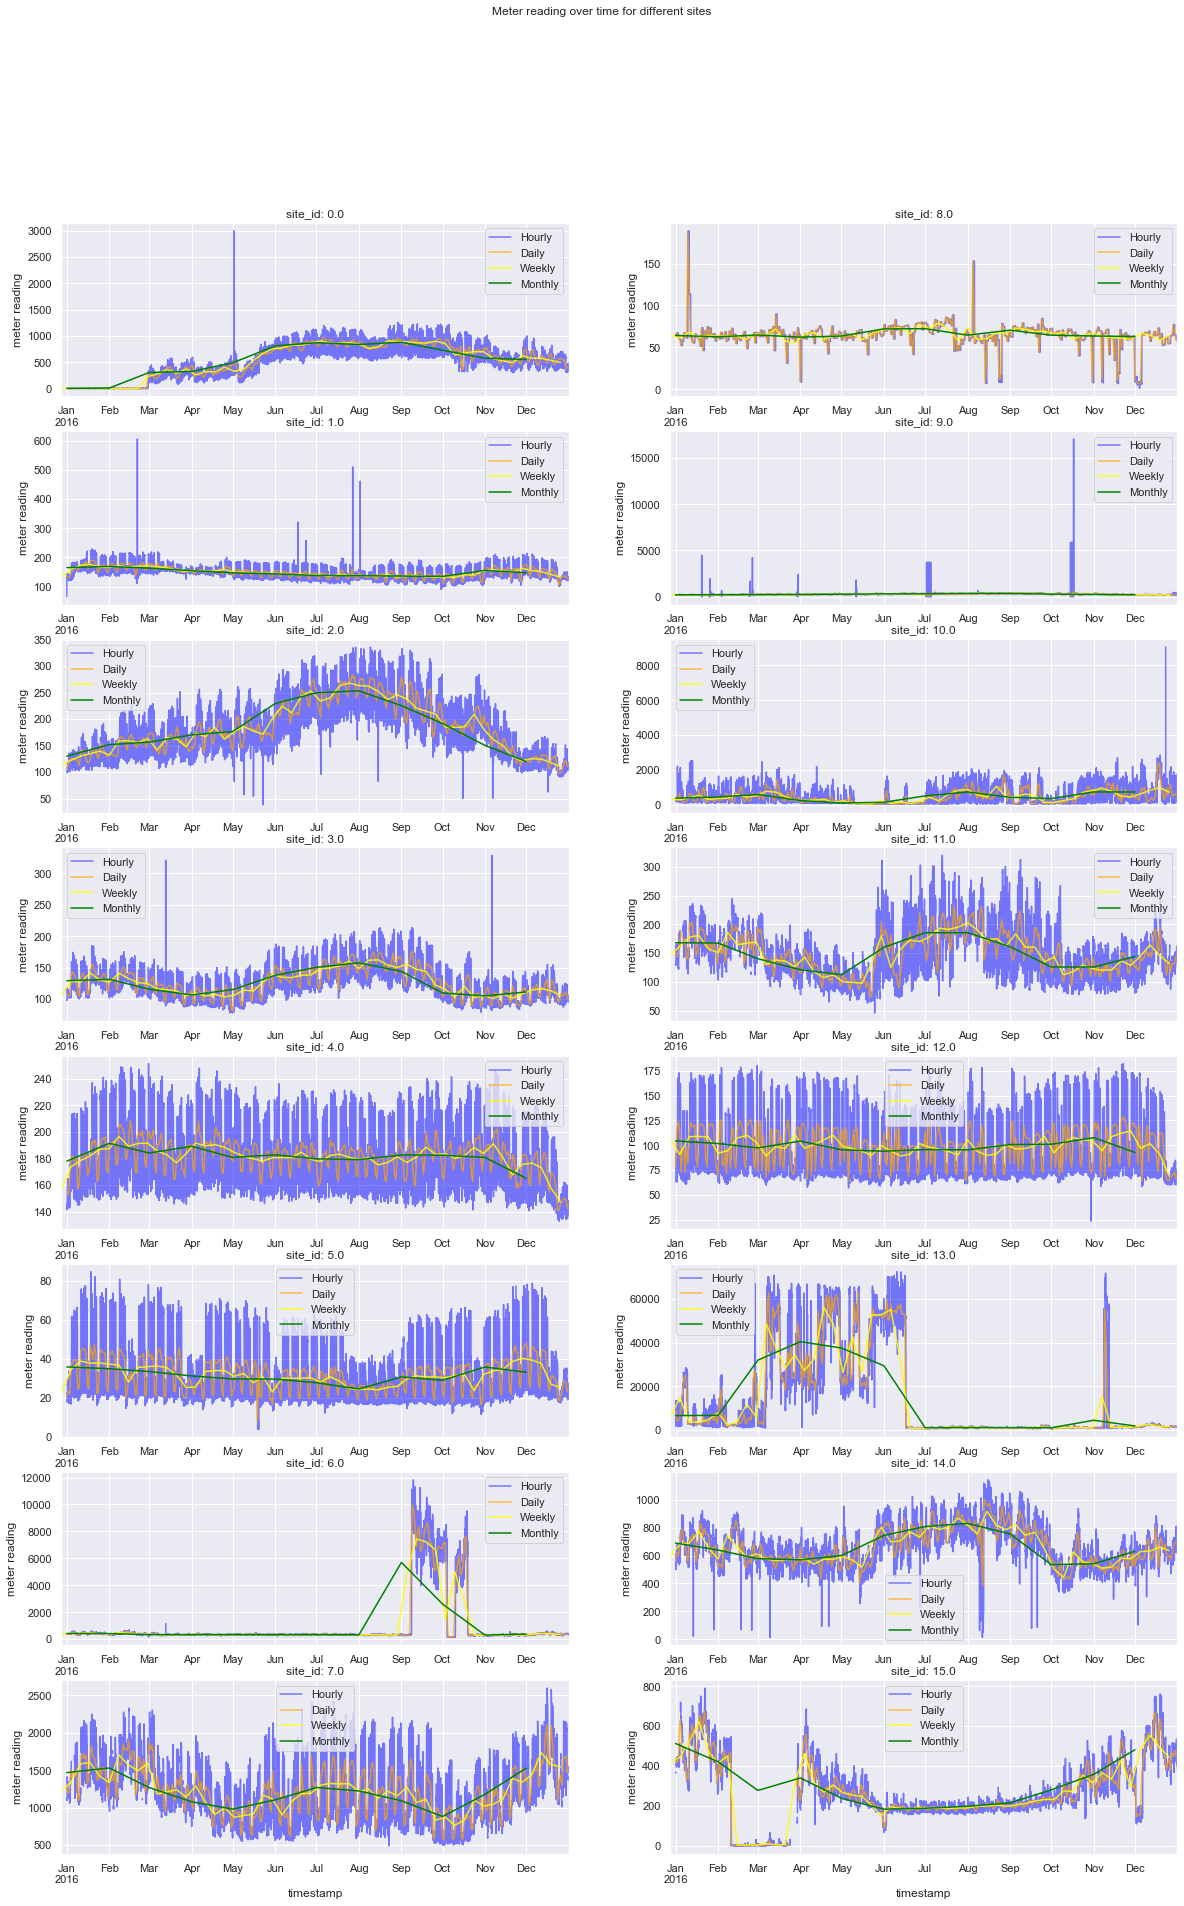

In [19]:
plt.clf()
grouped = train[["site_id", "timestamp", "meter_reading"]].groupby("site_id")
i = j = 0
fig, ax = plt.subplots(8, 2, figsize = (20, 30))
for name, group in grouped:
    group.set_index("timestamp").resample("H").mean()["meter_reading"].plot(ax = ax[i%8,i//8], label = "Hourly", color = "blue", alpha = 0.5)
    group.set_index("timestamp").resample("D").mean()["meter_reading"].plot(ax = ax[i%8,i//8], label = "Daily", color = "orange", alpha = 0.7)
    group.set_index("timestamp").resample("W").mean()["meter_reading"].plot(ax = ax[i%8,i//8], label = "Weekly", color = "yellow", alpha = 0.85)
    group.set_index("timestamp").resample("M").mean()["meter_reading"].plot(ax = ax[i%8,i//8], label = "Monthly", color = "green", alpha = 1)
    ax[i%8,i//8].set_title("site_id: " + str(name))
    ax[i%8,i//8].set_ylabel("meter reading")
    ax[i%8,i//8].legend()
    i+=1
plt.suptitle("Meter reading over time for different sites")
plt.show()